In [139]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append(os.path.abspath(".."))

from config import (
    TRANSFORMED_DATA_PATH,
    METADATA_PATH,
    TRAIN_DATA_PATH,
    VAL_DATA_PATH,
    TEST_DATA_PATH,
    METADATA_PATH,
)

In [9]:
# option to view entire pandas outputs 
# pd.set_option('display.max_rows', None)

# line of code to cancel the above display setting
# pd.reset_option('all')

### Main Exploratory Data Analysis (EDA)

In [19]:
# loading transformed data
transformed_df = pd.read_parquet("../" + TRANSFORMED_DATA_PATH)

# loading train data
train_df = pd.read_parquet("../" + TRAIN_DATA_PATH)

# loading validation data
val_df = pd.read_parquet("../" + VAL_DATA_PATH)

# loading test data
test_df = pd.read_parquet("../" + TEST_DATA_PATH)

# loading metadata
meta_df = pd.read_parquet("../" + METADATA_PATH)

# joining metadata onto the train, validation and test data
train_w_meta = pd.merge(train_df, meta_df, on="prd_number", how="left")
val_w_meta = pd.merge(val_df, meta_df, on="prd_number", how="left")
test_w_meta = pd.merge(test_df, meta_df, on="prd_number", how="left")

Summary statistics for transformed, train, validation and test data:

In [24]:
dataframes = [("transformed data", transformed_df), 
              ("train data", train_w_meta), 
              ("validation data", val_w_meta), 
              ("test data", test_w_meta)]

total_interactions = len(transformed_df)

for name, df in dataframes:
    # unique users
    n_users = len(df["user_id"].unique())
    print(f"Number of unique users in {name}: {n_users}")

    # unique shows
    n_shows = len(df["series_title"].unique())
    print(f"Number of unique shows in {name}: {n_shows}")

    # unique episodes
    n_episodes = len(df["prd_number"].unique())
    print(f"Number of unique episodes in {name}: {n_episodes}")

    # number of interactions
    n_interactions = len(df)
    print(f"Number of interactions in {name}: {n_interactions}")

    # percentage of total interactions
    perc_interactions = n_interactions / total_interactions
    print(f"% of total interactions in {name}: {perc_interactions*100:.2f}%\n")

Number of unique users in transformed data: 44007
Number of unique shows in transformed data: 595
Number of unique episodes in transformed data: 21056
Number of interactions in transformed data: 2365596
% of total interactions in transformed data: 100.00%

Number of unique users in train data: 44007
Number of unique shows in train data: 575
Number of unique episodes in train data: 15230
Number of interactions in train data: 1228193
% of total interactions in train data: 51.92%

Number of unique users in validation data: 44007
Number of unique shows in validation data: 568
Number of unique episodes in validation data: 11682
Number of interactions in validation data: 581287
% of total interactions in validation data: 24.57%

Number of unique users in test data: 44007
Number of unique shows in test data: 572
Number of unique episodes in test data: 11888
Number of interactions in test data: 556116
% of total interactions in test data: 23.51%



Top 5 podcast shows and episodes:

In [43]:
# top 5 podcast shows
unique_users_per_series = transformed_df.groupby(["series_title", "genre"])["user_id"].nunique()
unique_users_per_series_df = unique_users_per_series.reset_index(name="unique_user_count")
shows_sorted = unique_users_per_series_df.sort_values(by="unique_user_count", ascending=False)
print(shows_sorted[:5])

            series_title           genre  unique_user_count
202             Genstart      Aktualitet              27905
572                Tiden         Nyheder              22611
550  Stjerner og striber      Aktualitet              20313
310               Lyssky      Aktualitet              19641
118   Djævlen i detaljen  Fakta og debat              19053


In [42]:
# top 5 podcast episodes
unique_users_per_episode = transformed_df.groupby(["prd_number"])["user_id"].nunique()
unique_users_per_series_df = unique_users_per_episode.reset_index(name="unique_user_count")
shows_sorted = unique_users_per_series_df.sort_values(by="unique_user_count", ascending=False)
shows_sorted_w_meta = pd.merge(shows_sorted, meta_df, on="prd_number", how="left")
print(shows_sorted_w_meta[:5])

    prd_number  unique_user_count        series_title  \
0  11802450402              10055            Genstart   
1  16122492630               8561  Djævlen i detaljen   
2  16122492636               8041  Djævlen i detaljen   
3  16122492637               8003  Djævlen i detaljen   
4  16122493781               7935               Tyran   

                                        unique_title    pub_date  \
0             Genstart: Diez og bedraget_11802450402  2024-10-01   
1  Djævlen i detaljen: En ufattelig historie 1:3 ...  2024-09-04   
2  Djævlen i detaljen: Jehovas Vidner indefra_161...  2024-10-16   
3  Djævlen i detaljen: Smuglerkongerne 1:2 - Befr...  2024-10-23   
4   Tyran: Kim Il Sung & Kim Jong Il 1:4_16122493781  2024-10-03   

   episode_duration           genre branding_channel mother_channel  \
0              1826      Aktualitet           DR Lyd          DR P1   
1              1544  Fakta og debat           DR Lyd              -   
2              1668  Fakta og debat

Distribution of unique listeners for top 5000 episodes:

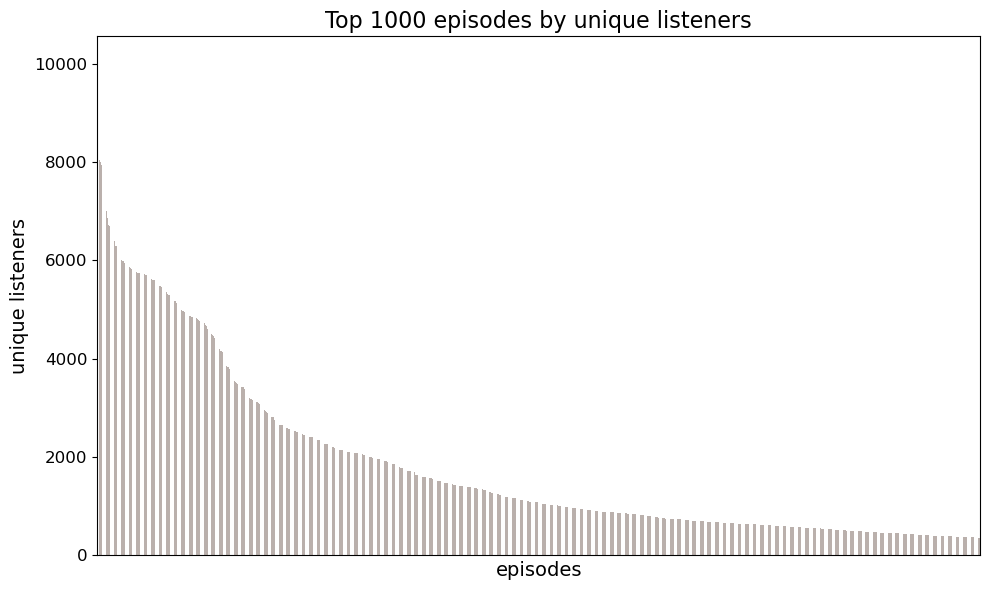

In [55]:
# counting occurrences of each prd_number
prd_counts = transformed_df['prd_number'].value_counts()

# sorting the occurences in descending order and selecting the top 5000 episodes 
x = 1000 
top_prd_counts = prd_counts.sort_values(ascending=False).head(x)

# plotting the top x bars
plt.figure(figsize=(10, 6))
top_prd_counts.plot(kind="bar", color="#bab0ac")

# formatting plot
plt.title(f"Top {x} episodes by unique listeners", fontsize=16)
plt.xlabel("episodes", fontsize=14)
plt.ylabel("unique listeners", fontsize=14)
plt.xticks([], []) 
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Distribution of unique listeners for all podcast shows:

<Figure size 1000x600 with 0 Axes>

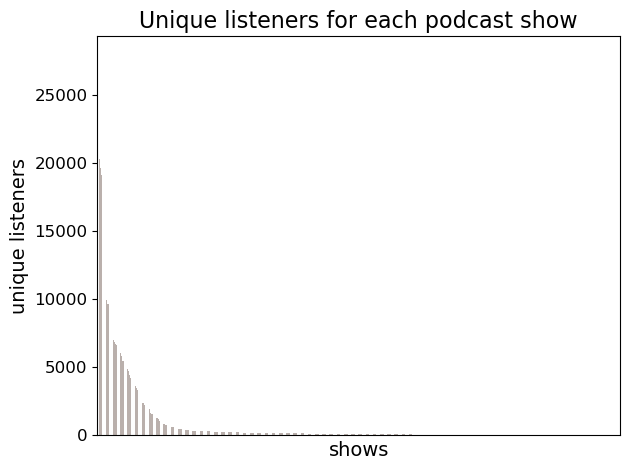

In [56]:
# counting occurrences of each prd_number
unique_users_per_series = transformed_df.groupby("series_title")["user_id"].nunique()
unique_users_per_series_df = unique_users_per_series.reset_index(name="unique_user_count")
shows_sorted = unique_users_per_series_df.sort_values(by="unique_user_count", ascending=False)

# plotting the top x bars
plt.figure(figsize=(10, 6))
shows_sorted.plot(kind="bar", color="#bab0ac")

# formatting plot
plt.title(f"Unique listeners for each podcast show", fontsize=16)
plt.xlabel("shows", fontsize=14)
plt.ylabel("unique listeners", fontsize=14)
plt.xticks([], []) 
plt.yticks(fontsize=12)
plt.legend().remove()
plt.tight_layout()
plt.show()

Sparsity of the user-show matrix for the CF recommender:

In [12]:
# grouping by user_id and series_title
grouped_df = train_w_meta.groupby(["user_id", "series_title"]).agg(
    avg_completion_rate =   ("completion_rate", "mean"),
    n_episodes =            ("prd_number", "count")
    ).reset_index()

# number of users
n_users_train = len(train_df["user_id"].unique())
print(f"Number of unique users in training data: {n_users_train}")

# number of podcast shows
n_shows_train = len(train_w_meta["series_title"].unique())
print(f"Number of unique podcast shows in training data: {n_shows_train}")

# number of user-show interactions 
user_show_interactions = len(grouped_df)
print(f"Number of user-show interactions: {user_show_interactions}")

# sparsity of the training interaction matrix
interaction_matrix_sparsity_train = 1 - (user_show_interactions / (n_users_train * n_shows_train))
print(f"The sparsity of the user-show matrix is {interaction_matrix_sparsity_train * 100:.2f}%")

Number of unique users in training data: 44007
Number of unique podcast shows in training data: 575
Number of user-show interactions: 352721
The sparsity of the user-show matrix is 98.61%


Unique listeners and episodes per genre:

In [132]:
# dictionary for translating genre names
translation_dict = {
    "Fakta og debat": "Factual & debate",
    "Aktualitet": "Current affairs",
    "Nyheder": "News",
    "Livsstil": "Lifestyle",
    "Unge": "Youth",
    "Kultur": "Culture",
    "Historie": "History",
    "Musik": "Music",
    "-": "-",
    "Dokumentar": "Documentary",
    "Sport": "Sports",
    "NN": "NN",
    "Underholdning": "Entertainment",
    "Kor og orkestre": "Choirs & orchestras",
}
transformed_df["genre_translated"] = transformed_df["genre"].replace(translation_dict)

# total listeners per genre
unique_users_per_genre = transformed_df.groupby("genre_translated")["user_id"].count()
print(unique_users_per_genre)

# unique episodes per genre
unique_episodes_per_genre = transformed_df.groupby("genre_translated")["prd_number"].nunique()
print(unique_episodes_per_genre)

# listeners per episode per genre
listeners_per_episode = unique_users_per_genre / unique_episodes_per_genre
listeners_per_episode_sorted = listeners_per_episode.sort_values(ascending=False)
print(listeners_per_episode_sorted)

genre_translated
-                       67906
Choirs & orchestras         6
Culture                111224
Current affairs        682590
Documentary             27534
Entertainment            2495
Factual & debate       578895
History                 81527
Lifestyle              180832
Music                   79262
NN                       2182
News                   334323
Sports                  26361
Youth                  169057
Name: user_id, dtype: int64
genre_translated
-                      2350
Choirs & orchestras       1
Culture                1562
Current affairs        2033
Documentary             173
Entertainment            89
Factual & debate       2155
History                 206
Lifestyle               551
Music                  3363
NN                       27
News                   5512
Sports                  387
Youth                  1524
Name: prd_number, dtype: int64
genre_translated
History                395.762136
Current affairs        335.755042
Lifestyle 

How many days after an episode has been publication are people listening?

In [84]:
# filtering out rows where the pub_date is equal to "-"
pd.set_option('display.max_rows', None)
transformed_df_pub_date_exist = transformed_df[transformed_df["pub_date"] != "-"]
transformed_df_pub_date_exist["pub_date"] = pd.to_datetime(transformed_df_pub_date_exist["pub_date"])
transformed_df_pub_date_exist["date"] = pd.to_datetime(transformed_df_pub_date_exist["date"])
transformed_df_pub_date_exist["days_since_pub"] = (transformed_df_pub_date_exist["date"] - transformed_df_pub_date_exist["pub_date"]).dt.days
transformed_df_pub_date_exist["days_since_pub"].value_counts()

C:\Users\sewr\AppData\Local\Temp\ipykernel_420\1099978418.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformed_df_pub_date_exist["pub_date"] = pd.to_datetime(transformed_df_pub_date_exist["pub_date"])
C:\Users\sewr\AppData\Local\Temp\ipykernel_420\1099978418.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformed_df_pub_date_exist["date"] = pd.to_datetime(transformed_df_pub_date_exist["date"])
C:\Users\sewr\AppData\Local\Temp\ipykernel_420\1099978418.py:6: SettingWithCopyWarning: 
A value

days_since_pub
 0       718005
 1       342302
 2       191443
 3       145011
 4       109518
 5        89452
 6        76577
 7        51971
 8        29005
 9        22900
 10       20375
 11       17897
 12       16219
 13       15381
 14       15287
 15       11837
 16       10033
 17        9454
 18        8611
 19        8414
 21        8286
 20        7958
 22        6773
 23        6072
 24        5789
 25        5499
 26        5158
 27        5002
 28        4991
 29        4307
 31        3822
 30        3765
 32        3599
 33        3541
 35        3342
 34        3309
 36        2927
 38        2765
 37        2736
 39        2640
 40        2579
 41        2299
 42        2289
 43        2002
 45        1922
 44        1817
 46        1791
 47        1728
 49        1698
 48        1691
 50        1620
 51        1442
 52        1435
 53        1421
 55        1387
 54        1349
 56        1200
 59        1164
 57        1157
 70        1149
 69        1142
 63      

C:\Users\sewr\AppData\Local\Temp\ipykernel_420\1901233698.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformed_df_pub_date_exist["pub_age_group"] = pd.cut(transformed_df_pub_date_exist["days_since_pub"],


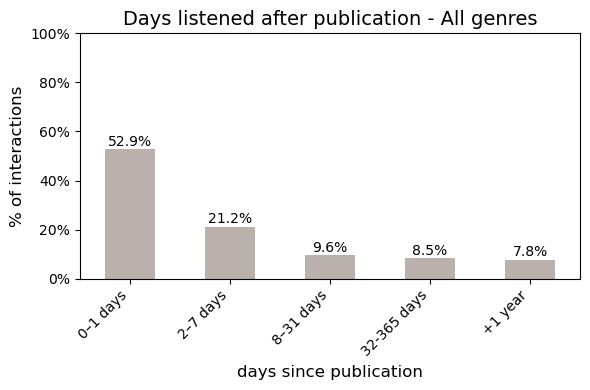

In [121]:
# binning the days_since_pub variable 
bins = [0, 2, 8, 32, 366, float('inf')]
labels = ["0–1 days", "2–7 days", "8–31 days", "32-365 days", "+1 year"]
transformed_df_pub_date_exist["pub_age_group"] = pd.cut(transformed_df_pub_date_exist["days_since_pub"], 
                                                        bins=bins, 
                                                        labels=labels, 
                                                        right=True, 
                                                        include_lowest=True)

# computing the proportion of each group
pub_age_group_proportions = transformed_df_pub_date_exist["pub_age_group"].value_counts(normalize=True).sort_index()

# plotting bar chart 
plt.figure(figsize=(6, 4))
ax = pub_age_group_proportions.plot(kind="bar", color="#bab0ac")

# add value labels on top of bars
for i, v in enumerate(pub_age_group_proportions):
    ax.text(i, v + 0.001, f"{v:.1%}", ha='center', va='bottom', fontsize=10)

# formatting the bar chart
plt.title("Days listened after publication - All genres", fontsize=14)
plt.xlabel("days since publication", fontsize=12)
plt.ylabel("% of interactions", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(top=1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))  
plt.tight_layout()
plt.show()

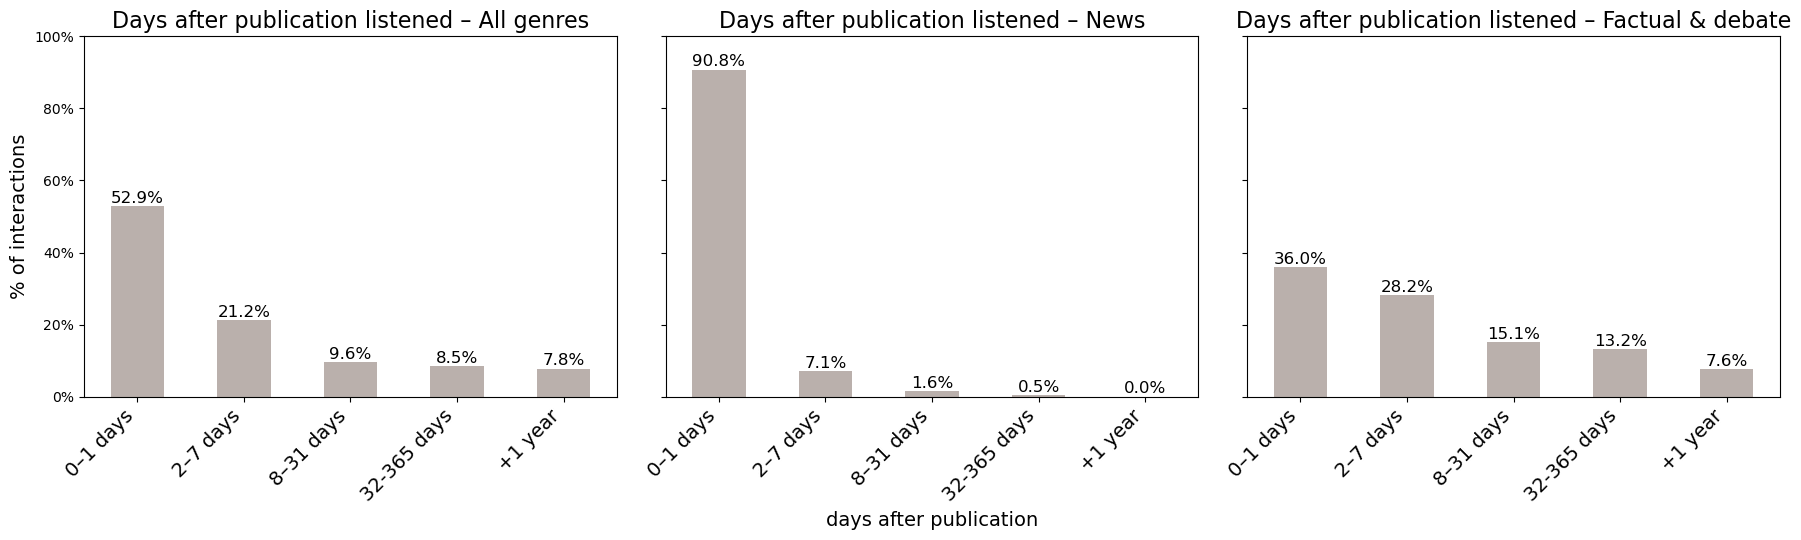

In [133]:
import matplotlib.pyplot as plt

# Prepare subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5.5), sharey=True)

genres = ["All", "Nyheder", "Fakta og debat"]
for i, genre in enumerate(genres):
    # compute proportions
    if genre == "All":
        props = transformed_df_pub_date_exist["pub_age_group"] \
                    .value_counts(normalize=True) \
                    .sort_index()
        title = "All genres"
    else:
        title = translation_dict[genre]
        dfg = transformed_df_pub_date_exist[transformed_df_pub_date_exist["genre"] == genre]
        props = dfg["pub_age_group"].value_counts(normalize=True).sort_index()

    ax = axes[i]
    props.plot(kind="bar", color="#bab0ac", ax=ax)

    # value labels
    for j, v in enumerate(props):
        ax.text(j, v + 0.001, f"{v:.1%}", ha='center', va='bottom', fontsize=12)

    # title
    ax.set_title(f"Days after publication listened – {title}", fontsize=16)

    # only first subplot gets y-label
    if i == 0:
        ax.set_ylabel("% of interactions", fontsize=14)
    else:
        ax.set_ylabel("")

    # only middle subplot gets x-label
    if i == 1:
        ax.set_xlabel("days after publication", fontsize=14)
    else:
        ax.set_xlabel("")

    # common formatting
    ax.set_xticklabels(props.index, rotation=45, ha='right', fontsize=14)
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

plt.tight_layout()
plt.show()


Boxplot of `completion_rate`:

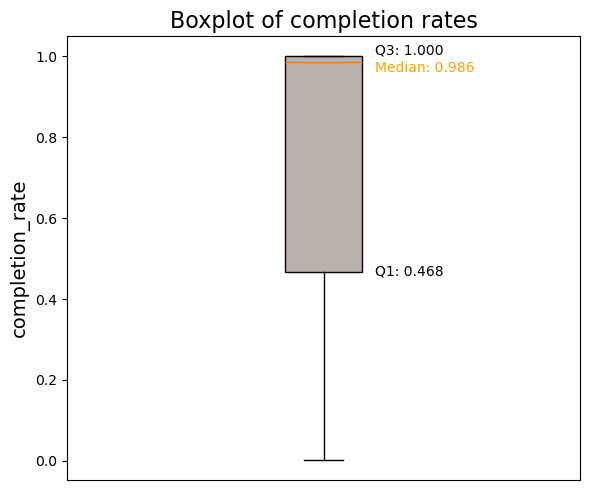

In [152]:
# extracting the completion_rate column from the transformed data
completion_rates = transformed_df["completion_rate"]

# create boxplot and capture the statistics
fig, ax = plt.subplots(figsize=(6, 5))
box = ax.boxplot(completion_rates, patch_artist=True)
for patch in box['boxes']:
    patch.set_facecolor("#bab0ac")
    
# computing quartiles
q1 = np.percentile(completion_rates, 25)
q2 = np.percentile(completion_rates, 50)  
q3 = np.percentile(completion_rates, 75)

# annotate quartiles
ax.text(1.1, q1, f"Q1: {q1:.3f}", va="center", fontsize=10, color="black")
ax.text(1.1, q2 - 0.015, f"Median: {q2:.3f}", va="center", fontsize=10, color="orange")
ax.text(1.1, q3 + 0.015, f"Q3: {q3:.3f}", va="center", fontsize=10, color="black")

# optional: annotate min and max (excluding outliers)
whiskers = [line.get_ydata()[1] for line in box["whiskers"]]

# format plot
ax.set_xticks([])
ax.set_ylabel("completion_rate", fontsize=14)
ax.set_title("Boxplot of completion rates", fontsize=16)

# manual legend for median line
ax.plot([], [], color="orange", label="Median")

plt.tight_layout()
plt.show()

### New Episodes in Test Data
Assessing how many of the episodes in the test data have been published after 2024-11-11 (the split date).  

This may be the reason why the CF recommender is performing badly - it is only able to recommend episodes from the training data.

In [8]:
# import test data
test_df = pd.read_parquet("../" + TEST_DATA_PATH)

# importing metadata
meta_df = pd.read_parquet("../" + METADATA_PATH)

# joining metadata onto the test data
test_w_meta_df = pd.merge(test_df, meta_df, on="prd_number", how="left")

# filtering on pub_date
test_df_filtered = test_w_meta_df[test_w_meta_df["pub_date"] >= "2024-11-11"]

# computing proportion with new episodes among test data
perc_new = len(test_df_filtered) / len(test_df) * 100
print(f"{perc_new:.2f}% of the test interactions involve episodes published after the split date (2024-11-11).")

69.31% of the test interactions involve episodes published after the split date (2024-11-11).


### Threshold for number of plays per episode
Checking how many unique episodes and interactions will be filtered away for different thresholds.

NB! The results below cannot be reproduced since it was performed before applying the filter to `01_filter.py`. 

In [ ]:
# loading filtered data
df = pd.read_parquet('../data/podcast_data_filtered.parquet')

# total number of interactions
n_interactions = len(df)

# grouping by prd_number and counting the number of appearances
prd_grp_df = df.groupby('prd_number')['user_id'].count().sort_values(ascending=True)
print(prd_grp_df.head(10))
n_episodes = len(prd_grp_df)
print(f"Number of unique episodes: {n_episodes}")

# testing different thresholds
thresholds = [5, 10, 20, 50]

episode_threshold_data = {"threshold": thresholds,
                          "episode%": [],
                          "interaction%": [],
                          }

# testing the thresholds
for threshold in thresholds:
    # filtering the DataFrame based on the threshold
    filtered_df = df[df['prd_number'].isin(prd_grp_df[prd_grp_df >= threshold].index)]

    # calculating the percentage of episodes and interactions
    episode_percentage = len(filtered_df['prd_number'].unique()) / n_episodes
    interaction_percentage = len(filtered_df) / n_interactions

    # appending the results to the data dictionary
    episode_threshold_data["episode%"].append(episode_percentage)
    episode_threshold_data["interaction%"].append(interaction_percentage)

# generating a dataframe from the gathered data on episodes
episode_threshold_df = pd.DataFrame(episode_threshold_data)
print(episode_threshold_df)

prd_number
19388840413    1
13332195418    1
14202412454    1
14202412456    1
14202410465    1
13332195424    1
13332195425    1
13332195426    1
13332195427    1
14202410481    1
Name: user_id, dtype: int64
Number of unique episodes: 22596
   threshold  episode%  interaction%
0          5  0.648212      0.995035
1         10  0.527438      0.988822
2         20  0.382767      0.973514
3         50  0.210878      0.932505


It might be reasonable to filter away episodes with less than 10 plays, as this will keep more than half of the episodes (52.7%) in the training data, while still keeping 98.9% of the interactions. 